In [1]:
import numpy as np
import os
os.environ["SCIPY_USE_PROPACK"] = "True"
import scipy
from scipy.sparse.linalg import svds as truncated_svd
from scipy.linalg import svd as plain_svd
from scipy.sparse.linalg import cg
import quimb as qu
import matplotlib.pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
def get_F_index(binary):
    # get index in original array
    # binary = sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    # F_index = sig_1^x sig_2^x ... sig_n_bits^x sig_1^y sig_2^y ... sig_n_bits^y
    return int(binary[::2]+binary[1::2], 2)

In [3]:
def svd(mat, chi=None):
    min_dim = np.min(mat.shape)
    if chi == None or chi >= min_dim:   # plain svd
        U, S, V = plain_svd(mat, full_matrices=False)
        S = np.diag(S)
    else:   # truncated svd
        chi_k = min_dim-1
        if chi < chi_k:
            chi_k = chi
        U, S, V = truncated_svd(mat, chi_k)
        S = np.diag(S)

    return U, S, V

In [4]:
def convert_to_MPS2D(F, chi=None):  # converts scalar field to scale-resolved MPS matrices
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation C
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    C_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        F_index = get_F_index(w)                # get original index for w
        C_index = int(w, 2)                     # get corresponding index for w
        w = bin(C_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        C_vec[0, C_index] = F_vec[0, F_index]   

    node = C_vec    # set first node of MPS
    MPS = []        # create MPS as list of matrices
    S_mats = []     # create list for singular value matrices 

    for i in range(n-1):
        # node = expand_rows(node, 4)     # move first index from columns to rows
        m, n = node.shape
        node = node.reshape((4*m, int(n/4)))
        U, S, V = svd(node, chi)        # svd
        MPS.append(U)                   # save U as first node of MPS
        S_mats.append(S)                # save S
        node = np.matmul(S, V)          # create remaining matrix S*V for next expansion step

    m, n = node.shape
    node = node.reshape((4*m, int(n/4)))
    MPS.append(node)    # add last node to MPS

    return MPS

In [5]:
def convert_to_VF2D(MPS):   # converts scale-resolved MPS matrices to scalar field
    n_bits = len(MPS)
    N = 2**n_bits
    node_L = MPS[0]
    for i in range(1, n_bits):
        m, n = node_L.shape
        node_R = MPS[i].reshape((n, -1))
        node_L = np.matmul(node_L, node_R)
        m, n = node_L.shape
        node_L = node_L.reshape((4*m, int(n/4)))
    C_vec = node_L.reshape((1, -1)) 

    w = '0'*2*n_bits                            # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    F_vec = np.zeros(4**n_bits).reshape((1, -1))     # similar to C but with dimensional indices

    for _ in range(4**n_bits):
        F_index = get_F_index(w)             
        C_index = int(w, 2)                   
        w = bin(C_index+1)[2:].zfill(2*n_bits)     
        F_vec[0, F_index]  = C_vec[0, C_index]

    return F_vec.reshape((N, N))

In [6]:
def convert_MPS_to_quimb(tensor_list, dim_ls):  # converts scale-resolved MPS matrices to quimb MPS
    arrays = []
    for i, tensor in enumerate(tensor_list):
        m, n = tensor.shape             # m = dim_left_bond*dim_ls, n = dim_right_bond
        dim_left_bond = int(m/dim_ls)   # dimension of left bond
        dim_right_bond = n              # dimension of right bond
        if dim_left_bond == 1:          # the first tensor as no left bond
            data = tensor.reshape((dim_ls, dim_right_bond)).transpose()
        elif dim_right_bond == 1:       # the last tensor has no right bond
            data = tensor.reshape((dim_left_bond, dim_ls)).transpose()
        else:
            data = tensor.reshape((dim_left_bond, dim_ls, dim_right_bond))
        arrays.append(data)
    
    return qu.tensor.MatrixProductState(arrays, shape='lpr')


In [7]:
def convert_MPS_to_quimb_old(tensor_list, dim_ls):
    arrays = []
    for i, tensor in enumerate(tensor_list):
        m, n = tensor.shape
        dim_left_bond = int(m/dim_ls)
        dim_right_bond = n
        data = tensor.reshape((dim_left_bond, dim_ls, dim_right_bond))
        arrays.append(data)
    
    return qu.tensor.MatrixProductState(arrays, shape='lpr')


In [8]:
def Diff_1_2_y_MPO(n, dx):
    # first order derivative with second order precision in y direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    right_terminator = 1/dx*np.array([0, 1/2, -1/2]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [9]:
def Diff_1_2_x_MPO(n, dx):
    # first order derivative with second order precision in x direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    right_terminator = 1/dx*np.array([0, 1/2, -1/2]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [10]:
def Diff_2_2_y_MPO(n, dx):
    # second order derivative with second order precision in y direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    right_terminator = 1/dx**2*np.array([-2, 1, 1]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [11]:
def Diff_2_2_x_MPO(n, dx):
    # second order derivative with second order precision in x direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    right_terminator = 1/dx**2*np.array([-2, 1, 1]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [12]:
def Diff_1_8_y_MPO(n, dx):
    # first order derivative with eigth order precision in y direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    sec_last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    sec_last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    sec_last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    sec_last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    sec_last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    sec_last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = -1   # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = -1   # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = -1   # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = -1   # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 1, 4] = 1    # 00 -> 01 carry for addition (1)
    last_node[1, 3, 0, 4] = 1    # 01 -> 00 carry for addition one further (3)
    last_node[2, 1, 3, 4] = 1    # 10 -> 11 carry for addition (1)
    last_node[3, 3, 2, 4] = 1    # 11 -> 10 carry for addition one further (3)
    last_node[0, 4, 1, 4] = -1   # 00 -> 01 carry for substraction one further (4)
    last_node[1, 2, 0, 4] = -1   # 01 -> 00 carry for substraction (2)
    last_node[2, 4, 3, 4] = -1   # 10 -> 11 carry for substraction one further (4)
    last_node[3, 2, 2, 4] = -1   # 11 -> 10 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = -1   # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = -1   # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = -1   # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = -1   # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx*np.array([0, 4/5, -4/5, -1/5, 4/105, -1/280]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [13]:
def Diff_1_8_x_MPO(n, dx):
    # first order derivative with eighth order precision in x direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    sec_last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    sec_last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    sec_last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    sec_last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    sec_last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    sec_last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = -1   # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = -1   # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = -1   # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = -1   # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 2, 4] = 1    # 00 -> 10 carry for addition (1)
    last_node[1, 1, 3, 4] = 1    # 01 -> 11 carry for addition (1)
    last_node[2, 3, 0, 4] = 1    # 10 -> 00 carry for addition one further (3)
    last_node[3, 3, 1, 4] = 1    # 11 -> 01 carry for addition one further (3)
    last_node[0, 4, 2, 4] = -1   # 00 -> 10 carry for substraction one further (4)
    last_node[1, 4, 3, 4] = -1   # 01 -> 11 carry for substraction one further (4)
    last_node[2, 2, 0, 4] = -1   # 10 -> 00 carry for substraction (2)
    last_node[3, 2, 1, 4] = -1   # 11 -> 01 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = -1   # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = -1   # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = -1   # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = -1   # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx*np.array([0, 4/5, -4/5, -1/5, 4/105, -1/280]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [14]:
def Diff_2_8_y_MPO(n, dx):
    # second order derivative with eigth order precision in y direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    sec_last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    sec_last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    sec_last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    sec_last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    sec_last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    sec_last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = 1    # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = 1    # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = 1    # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = 1    # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 1, 4] = 1    # 00 -> 01 carry for addition (1)
    last_node[1, 3, 0, 4] = 1    # 01 -> 00 carry for addition one further (3)
    last_node[2, 1, 3, 4] = 1    # 10 -> 11 carry for addition (1)
    last_node[3, 3, 2, 4] = 1    # 11 -> 10 carry for addition one further (3)
    last_node[0, 4, 1, 4] = 1    # 00 -> 01 carry for substraction one further (4)
    last_node[1, 2, 0, 4] = 1    # 01 -> 00 carry for substraction (2)
    last_node[2, 4, 3, 4] = 1    # 10 -> 11 carry for substraction one further (4)
    last_node[3, 2, 2, 4] = 1    # 11 -> 10 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = 1    # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = 1    # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = 1    # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = 1    # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx**2*np.array([-205/72, 8/5, 8/5, -1/5, 8/315, -1/560]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [15]:
def Diff_2_8_x_MPO(n, dx):
    # second order derivative with eighth order precision in x direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    sec_last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    sec_last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    sec_last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    sec_last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    sec_last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    sec_last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = 1    # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = 1    # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = 1    # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = 1    # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 2, 4] = 1    # 00 -> 10 carry for addition (1)
    last_node[1, 1, 3, 4] = 1    # 01 -> 11 carry for addition (1)
    last_node[2, 3, 0, 4] = 1    # 10 -> 00 carry for addition one further (3)
    last_node[3, 3, 1, 4] = 1    # 11 -> 01 carry for addition one further (3)
    last_node[0, 4, 2, 4] = 1    # 00 -> 10 carry for substraction one further (4)
    last_node[1, 4, 3, 4] = 1    # 01 -> 11 carry for substraction one further (4)
    last_node[2, 2, 0, 4] = 1    # 10 -> 00 carry for substraction (2)
    last_node[3, 2, 1, 4] = 1    # 11 -> 01 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = 1    # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = 1    # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = 1    # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = 1    # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx**2*np.array([-205/72, 8/5, 8/5, -1/5, 8/315, -1/560]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(4, 4, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [16]:
def hadamard_product_MPO(a_MPS, chi):
    phys_dim = a_MPS.phys_dim(0)    # get the size of each physical index
    k_delta = np.zeros((phys_dim, phys_dim, phys_dim))  # initialize kronecker delta as np.array
    for i in range(phys_dim):
        k_delta[i, i, i] = 1    # only set variables to one where each index is the same
    temp_MPS = a_MPS.copy()
    for i in range(temp_MPS.L):
        delta = qu.tensor.Tensor(k_delta, inds=(f'k{i}', f'a{i}', f'b{i}'), tags=f'I{i}')   # create a kronecker delta tensor for each individual leg of the MPS
        temp_MPS = temp_MPS & delta     # connect kronecker delta tensor to MPS
        temp_MPS = temp_MPS ^ f'I{i}'   # contract kronecker delta tensor to MPS

    data = list(temp_MPS.arrays)    # convert TN to list of np.arrays in order to convert it to quimb MPO
    data[0] = data[0].transpose((1, 2, 0))   # reorder indices for first tensor (quimb speciality)
    result_MPO = qu.tensor.MatrixProductOperator(data, shape='dulr')    # create quimb MPO
    # result_MPO.compress(max_bond=chi)
    # result_MPO.compress()
    
    return result_MPO   # return the MPO

In [17]:
# Genaral parameters
n = 4                          # number of qubits
N = 2**n                        # number of grid points
dx = 1 / (N-1)                  # finite spacing
dt = 0.1*2**-(n-1)                     # finite time step
chi = N
T = 2                           # final time
x = np.linspace(0, 1-dx, N)
y = np.linspace(0, 1-dx, N)
X, Y = np.meshgrid(x, y)
u_0 = 1                         # initial velocity
Re = 200*1e3
L_box = 1                       # domain size
mu = dx**2 * 10**4
# mu = 6.25 * 10**4


In [18]:
def copy_mps(MPS):
    return qu.tensor.MatrixProductState(MPS.arrays)

In [31]:
def cost_function(U, V, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, t, Re, mu):
    d1x = Diff_1_8_x_MPO(n, dx)
    d1y = Diff_1_8_y_MPO(n, dx)
    d2x = Diff_2_8_x_MPO(n, dx)
    d2y = Diff_2_8_y_MPO(n, dx)

    d1x_d1x = d1x.apply(d1x, compress=True)
    d1x_d1y = d1x.apply(d1y, compress=True)
    d1y_d1y = d1y.apply(d1y, compress=True)
    
    # create MPOs for convection-diffusion terms
    Bx_MPO = hadamard_product_MPO(copy_mps(Bx_MPS), chi)
    Bxd1x = Bx_MPO.apply(d1x, compress=True)
    d1xBx = d1x.apply(Bx_MPO, compress=True)
    By_MPO = hadamard_product_MPO(copy_mps(By_MPS), chi)
    Byd1y = By_MPO.apply(d1y, compress=True)
    d1yBy = d1y.apply(By_MPO, compress=True)

    cost_c = 0

    # continuity equation
    continuity_state = (d1x.apply(U, compress=True) + d1y.apply(V, compress=True))
    cost_c += mu * (continuity_state.H @ continuity_state)

    cost_m = 0

    # momentum equation for x
    momentum_x = (U-Ax_MPS)/dt
    momentum_x += 0.5 * Bxd1x.apply(Bx_MPS, compress=True)
    momentum_x += 0.5 * d1xBx.apply(Bx_MPS, compress=True)
    momentum_x += 0.5 * Byd1y.apply(Bx_MPS, compress=True)
    momentum_x += 0.5 * d1yBy.apply(Bx_MPS, compress=True)
    momentum_x += -1/Re * d2x.apply(Bx_MPS, compress=True)
    momentum_x += -1/Re * d2y.apply(Bx_MPS, compress=True)

    cost_m += momentum_x.H @ momentum_x

    # momentum equation for y
    momentum_y = (V-Ay_MPS)/dt
    momentum_y += 0.5 * Bxd1x.apply(By_MPS, compress=True)
    momentum_y += 0.5 * d1xBx.apply(By_MPS, compress=True)
    momentum_y += 0.5 * Byd1y.apply(By_MPS, compress=True)
    momentum_y += 0.5 * d1yBy.apply(By_MPS, compress=True)
    momentum_y += -1/Re * d2x.apply(By_MPS, compress=True)
    momentum_y += -1/Re * d2y.apply(By_MPS, compress=True)

    cost_m += momentum_y.H @ momentum_y

    return cost_c+cost_m, cost_c, cost_m

In [32]:
u = np.load("/Users/q556220/dev/TN_CFD/2D_TDJ/data/u_0.05.npy")
v = np.load("/Users/q556220/dev/TN_CFD/2D_TDJ/data/v_0.05.npy")

In [33]:
MPS_U = convert_to_MPS2D(u, chi)
MPS_V = convert_to_MPS2D(v, chi)

# Tranform into quimb MPS form
U_q = convert_MPS_to_quimb(MPS_U, 4)
V_q = convert_MPS_to_quimb(MPS_V, 4)

In [34]:
cost_function(U_q, V_q, copy_mps(U_q), copy_mps(V_q), copy_mps(U_q), copy_mps(V_q), chi, dt, 0, Re, mu)

(254864.30246024992, 254506.2585284222, 358.0439318277366)

In [35]:
uv_list = []
random_list = []
time_list = []
for file in os.listdir("/Users/q556220/dev/TN_CFD/2D_TDJ/data"):
    if file.startswith("u"):
        u = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/data/{file}")
        v = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/data/v{file[1:]}")
        u = u.T
        v = v.T
        random = np.random.rand(16, 16)
        MPS_U = convert_to_MPS2D(u, chi)
        MPS_V = convert_to_MPS2D(v, chi)
        MPS_random = convert_to_MPS2D(random, chi)
        U_q = convert_MPS_to_quimb(MPS_U, 4)
        V_q = convert_MPS_to_quimb(MPS_V, 4)
        V_random = convert_MPS_to_quimb(MPS_random, 4)
        random_list.append(V_random)

        uv_list.append((U_q, V_q))
        time_list.append(float(file[2:-4]))

sorted_uv_list = [x for _,x in sorted(zip(time_list,uv_list))]
sorted_time_list = [x for x,_ in sorted(zip(time_list,uv_list))]

In [36]:
cost_list = []
cost_c_list = []
cost_m_list = []
cost_r_list = []
cost_c_r_list = []
cost_m_r_list = []

for i in range(1,len(uv_list)):
    U = copy_mps(sorted_uv_list[i][0])
    V = copy_mps(sorted_uv_list[i][1])
    Ax_MPS = copy_mps(sorted_uv_list[i-1][0])
    Ay_MPS = copy_mps(sorted_uv_list[i-1][1])
    Bx_MPS = copy_mps(sorted_uv_list[i-1][0])
    By_MPS = copy_mps(sorted_uv_list[i-1][1])
    cost, cost_c, cost_m = cost_function(U, V, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, sorted_time_list[i], Re, mu)
    cost_r, cost_c_r, cost_m_r = cost_function(random_list[i], random_list[i], Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, sorted_time_list[i], Re, mu)

    cost_list.append(cost)
    cost_c_list.append(cost_c)
    cost_m_list.append(cost_m)

    cost_r_list.append(cost_r)
    cost_c_r_list.append(cost_c_r)
    cost_m_r_list.append(cost_m_r)

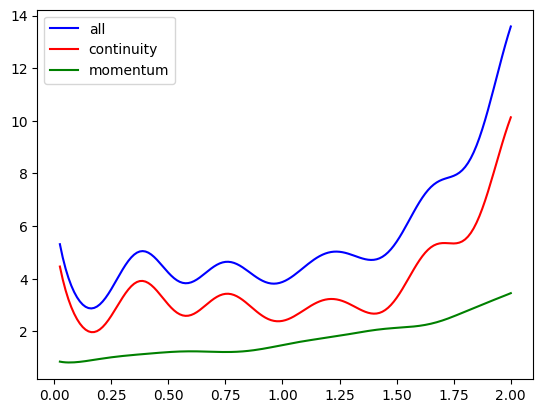

In [39]:
plt.plot(sorted_time_list[1:], cost_list, c='blue', label="all")
# plt.plot(sorted_time_list[1:], [i/mu for i in cost_c_list], c='red', label="continuity")
plt.plot(sorted_time_list[1:], cost_c_list, c='red', label="continuity")
plt.plot(sorted_time_list[1:], cost_m_list, c='green', label="momentum")
# plt.plot(sorted_time_list[1:], cost_c_r_list, c='black', label="random continuity")
# plt.plot(sorted_time_list[1:], cost_m_r_list, c='orange', label="random momentum")
plt.legend()
plt.show()

# Testing the C tensors from classical simulation

In [28]:
def build_LS(i, U, V, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, Re, mu):
    n = U.L                     # size of MPS
    dx = 1 / (2**n - 1)
    d1x = Diff_1_8_x_MPO(n, dx)
    d1y = Diff_1_8_y_MPO(n, dx)
    d2x = Diff_2_8_x_MPO(n, dx)
    d2y = Diff_2_8_y_MPO(n, dx)

    d1x_d1x = d1x.apply(d1x, compress=True)
    d1x_d1y = d1x.apply(d1y, compress=True)
    d1y_d1y = d1y.apply(d1y, compress=True)

    # create MPOs for convection-diffusion terms
    Bx_MPO = hadamard_product_MPO(copy_mps(Bx_MPS), chi)
    Bxd1x = Bx_MPO.apply(d1x, compress=True)
    d1xBx = d1x.apply(Bx_MPO, compress=True)
    By_MPO = hadamard_product_MPO(copy_mps(By_MPS), chi)
    Byd1y = By_MPO.apply(d1y, compress=True)
    d1yBy = d1y.apply(By_MPO, compress=True)

    U.right_canonize()
    V.right_canonize()
    U.shift_orthogonality_center(0, i)
    V.shift_orthogonality_center(0, i)
    
    # Build linear system Ax = b 
    # Prepare individual tensor nodes
    U_mps = copy_mps(U)
    V_mps = copy_mps(V)

    Ax_mps = copy_mps(Ax_MPS)
    Ay_mps = copy_mps(Ay_MPS)

    Bx_mps = copy_mps(Bx_MPS)
    By_mps = copy_mps(By_MPS)
    if i == 0:
        l = 1
        r = U_mps[i].shape[0]
        p = U_mps[i].shape[1]
    else:
        l = U_mps[i].shape[0]
        r = U_mps[i].shape[1]
        p = U_mps[i].shape[2]
    
    # H_11 = np.zeros(l*r*p)
    H_11 = np.zeros((l*r*p, l*r*p))
    H_12 = np.zeros_like(H_11)
    H_22 = np.zeros_like(H_11)

    b_1 = np.zeros((l*r*p))
    b_2 = np.zeros_like(b_1)
    for L in range(l):
        for R in range(r):
            for D in range(p):
                basis = np.zeros((l, r, p))
                basis[L, R, D] = 1
                if i == 0:
                    basis = basis.reshape((r, p))
                U_mps_list = list(U_mps.arrays)
                U_mps_list[i] = basis
                basis_x_mps = qu.tensor.MatrixProductState(U_mps_list)
                V_mps_list = list(V_mps.arrays)
                V_mps_list[i] = basis
                basis_y_mps = qu.tensor.MatrixProductState(V_mps_list)

                # H_11[L*r*p + R*p + D] = basis_x_mps @ d1x_d1x.apply(basis_x_mps, compress=True, max_bond=chi)
                # H_12[L*r*p + R*p + D] = basis_x_mps @ d1x_d1y.apply(basis_y_mps, compress=True, max_bond=chi)
                # H_22[L*r*p + R*p + D] = basis_y_mps @ d1y_d1y.apply(basis_y_mps, compress=True, max_bond=chi)
                calc = True
                H_11_c = np.zeros(p)
                H_12_c = np.zeros(p)
                H_22_c = np.zeros(p)
                for L_ in range(l):
                    for R_ in range(r):
                        for D_ in range(p):
                            if calc:
                                basis = np.zeros((l, r, p))
                                basis[L_, R_, D_] = 1
                                if i == 0:
                                    basis = basis.reshape((r, p))
                                U_mps_list = list(U_mps.arrays)
                                U_mps_list[i] = basis
                                basis_x_mps_ = qu.tensor.MatrixProductState(U_mps_list)
                                V_mps_list = list(V_mps.arrays)
                                V_mps_list[i] = basis
                                basis_y_mps_ = qu.tensor.MatrixProductState(V_mps_list)

                                H_11_c[D_] = basis_x_mps @ d1x_d1x.apply(basis_x_mps_, compress=True, max_bond=chi)
                                H_12_c[D_] = basis_x_mps @ d1x_d1y.apply(basis_y_mps_, compress=True, max_bond=chi)
                                H_22_c[D_] = basis_y_mps @ d1y_d1y.apply(basis_y_mps_, compress=True, max_bond=chi)
                            
                            H_11[L*r*p + R*p + D, L_*r*p + R_*p + D_] = H_11_c[D_]
                            H_12[L*r*p + R*p + D, L_*r*p + R_*p + D_] = H_12_c[D_]
                            H_22[L*r*p + R*p + D, L_*r*p + R_*p + D_] = H_22_c[D_]

                        calc = False



                b_1[L*r*p + R*p + D] = basis_x_mps @ Ax_mps
                b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ Bxd1x.apply(Bx_mps, compress=True, max_bond=chi)
                b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ d1xBx.apply(Bx_mps, compress=True, max_bond=chi)
                b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ Byd1y.apply(Bx_mps, compress=True, max_bond=chi)
                b_1[L*r*p + R*p + D] += -dt/2 * basis_x_mps @ d1yBy.apply(Bx_mps, compress=True, max_bond=chi)
                b_1[L*r*p + R*p + D] += dt/Re * basis_x_mps @ d2x.apply(Bx_mps, compress=True, max_bond=chi)
                b_1[L*r*p + R*p + D] += dt/Re * basis_x_mps @ d2y.apply(Bx_mps, compress=True, max_bond=chi)

                b_2[L*r*p + R*p + D] = basis_y_mps @ Ay_mps
                b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ Bxd1x.apply(By_mps, compress=True, max_bond=chi)
                b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ d1xBx.apply(By_mps, compress=True, max_bond=chi)
                b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ Byd1y.apply(By_mps, compress=True, max_bond=chi)
                b_2[L*r*p + R*p + D] += -dt/2 * basis_y_mps @ d1yBy.apply(By_mps, compress=True, max_bond=chi)
                b_2[L*r*p + R*p + D] += dt/Re * basis_y_mps @ d2x.apply(By_mps, compress=True, max_bond=chi)
                b_2[L*r*p + R*p + D] += dt/Re * basis_y_mps @ d2y.apply(By_mps, compress=True, max_bond=chi)

    H = np.block([[H_11, H_12], [H_12.T, H_22]])
    A = np.eye(len(H)) - mu*dt**2 * H
    b = np.concatenate((b_1, b_2))

    # print(np.all(np.linalg.eigvals(A) > 0))
    # x = np.linalg.solve(A,b)
    # U_new, V_new = np.array_split(x, 2)
    
    x_1 = U[i].data.flatten()
    x_2 = V[i].data.flatten()
    x = np.concatenate((x_1, x_2))

    residual = np.linalg.norm(A.dot(x) - b)
    print(residual)

    return A, x, b, residual

In [297]:
A_list = []
x_list = []
b_list = []
residual_list = []
for i in range(1,len(uv_list)):
    U = copy_mps(sorted_uv_list[i][0])
    V = copy_mps(sorted_uv_list[i][1])
    Ax_MPS = copy_mps(sorted_uv_list[i-1][0])
    Ay_MPS = copy_mps(sorted_uv_list[i-1][1])
    Bx_MPS = copy_mps(sorted_uv_list[i-1][0])
    By_MPS = copy_mps(sorted_uv_list[i-1][1])
    A, x, b, residual = build_LS(0, U, V, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, Re, mu)
    
    A_list.append(A)
    x_list.append(X)
    b_list.append(b)
    residual_list.append(residual)

0.0376031811568309


KeyboardInterrupt: 

In [25]:
uv_list = []
random_list = []
time_list = []
for file in os.listdir("/Users/q556220/dev/TN_CFD/2D_TDJ/UV"):
    if file.startswith("U"):
        u = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/UV/{file}", allow_pickle=True)
        v = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/UV/V{file[1:]}", allow_pickle=True)
        u = qu.tensor.MatrixProductState(u)
        v = qu.tensor.MatrixProductState(v)

        uv_list.append((u, v))
        time_list.append(float(file[2:-4]))

sorted_uv_list = [x for _,x in sorted(zip(time_list,uv_list))]
sorted_time_list = [x for x,_ in sorted(zip(time_list,uv_list))]

In [30]:
A_list = []
x_list = []
b_list = []
residual_list = []
for i in range(1,len(uv_list)):
    U = copy_mps(sorted_uv_list[i][0])
    V = copy_mps(sorted_uv_list[i][1])
    Ax_MPS = copy_mps(sorted_uv_list[i-1][0])
    Ay_MPS = copy_mps(sorted_uv_list[i-1][1])
    Bx_MPS = copy_mps(sorted_uv_list[i-1][0])
    By_MPS = copy_mps(sorted_uv_list[i-1][1])
    A, x, b, residual = build_LS(0, U, V, Ax_MPS, Ay_MPS, Bx_MPS, By_MPS, chi, dt, Re, mu)
    
    A_list.append(A)
    x_list.append(X)
    b_list.append(b)
    residual_list.append(residual)

0.19955903628815178
0.19178146567633222
0.18414283714738175
0.17609067094968145
0.16796346155137093
0.16006811079282354
0.15266206083658562
0.14596408448203968
0.14011110717353936
0.1351509002873034
0.13107282618304975
0.12784395947348376
0.12542223185137716
0.12378056694744329
0.12291875823908778
0.12286120824962668
0.12364995204745612
0.12533728414171308
0.1279788022274654
0.13162188949091252
0.13629134581520158
0.1419712275786124
0.14858926006178394
0.156021572660793
0.16410956459552917
0.17268427689182062
0.18158615295024927
0.19066799018298286
0.1997831789182747
0.20874976376908538
0.2172473081990449
0.22459358819969982
0.22980633084774368
0.2327066404985811
0.2342195353982543
0.2350389291865796
0.23531358668596275
0.2350744768145657
0.23445255215568367
0.23368623422162763
0.23301878659461447
0.2327208283740406
0.23306004655881438
0.23430391110226675
0.236737473876289
0.24061881243421035
0.2461184504668313
0.253250222456974
0.261792640312374
0.27126492133209423
0.2809701684682363


KeyboardInterrupt: 

# Compare matrices

In [279]:
H_11_a = {}
H_12_a = {}
H_22_a = {}

H_11_m = {}
H_12_m = {}
H_22_m = {}

for file in os.listdir("/Users/q556220/dev/TN_CFD/2D_TDJ/H"):
    if file.startswith("H_11"):
        H = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H/{file}")
        H_11_a[int(file[5])] = H
    elif file.startswith("H_12"):
        H = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H/{file}")
        H_12_a[int(file[5])] = H
    elif file.startswith("H_22"):
        H = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H/{file}")
        H_22_a[int(file[5])] = H

for file in os.listdir("/Users/q556220/dev/TN_CFD/2D_TDJ/H_"):
    if file.startswith("H_11"):
        H = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H_/{file}")
        H_11_m[int(file[5])] = H
    elif file.startswith("H_12"):
        H = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H_/{file}")
        H_12_m[int(file[5])] = H
    elif file.startswith("H_22"):
        H = np.load(f"/Users/q556220/dev/TN_CFD/2D_TDJ/H_/{file}")
        H_22_m[int(file[5])] = H

# H_11_a[0] = H_11_a[0].reshape(4, 4, 4, 4).transpose((1, 0, 3, 2)).reshape(16, 16)
# H_12_a[0] = H_12_a[0].reshape(4, 4, 4, 4).transpose((1, 0, 3, 2)).reshape(16, 16)
# H_22_a[0] = H_22_a[0].reshape(4, 4, 4, 4).transpose((1, 0, 3, 2)).reshape(16, 16)

# H_11_a[1] = H_11_a[1].reshape(4, 4, 16, 4, 4, 16).transpose((0, 2, 1, 3, 5, 4)).reshape(256, 256)
# H_12_a[1] = H_12_a[1].reshape(4, 4, 16, 4, 4, 16).transpose((0, 2, 1, 3, 5, 4)).reshape(256, 256)
# H_22_a[1] = H_22_a[1].reshape(4, 4, 16, 4, 4, 16).transpose((0, 2, 1, 3, 5, 4)).reshape(256, 256)

# H_11_a[2] = H_11_a[2].reshape(16, 4, 4, 16, 4, 4).transpose((0, 2, 1, 3, 5, 4)).reshape(256, 256)
# H_12_a[2] = H_12_a[2].reshape(16, 4, 4, 16, 4, 4).transpose((0, 2, 1, 3, 5, 4)).reshape(256, 256)
# H_22_a[2] = H_22_a[2].reshape(16, 4, 4, 16, 4, 4).transpose((0, 2, 1, 3, 5, 4)).reshape(256, 256)

In [40]:
plt.imshow(H_11_a[1])
print(np.min(H_11_a[0]))

NameError: name 'H_11_a' is not defined

-298.95636033398796


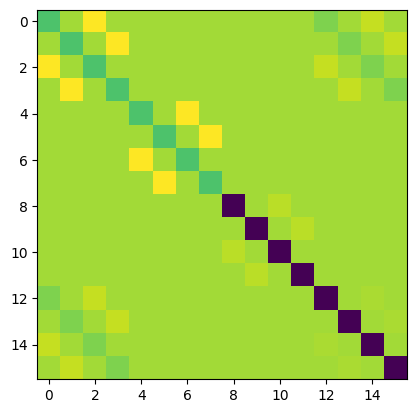

In [281]:
plt.imshow(H_11_m[0])
print(np.min(H_11_m[0]))

0.0003625263263216335


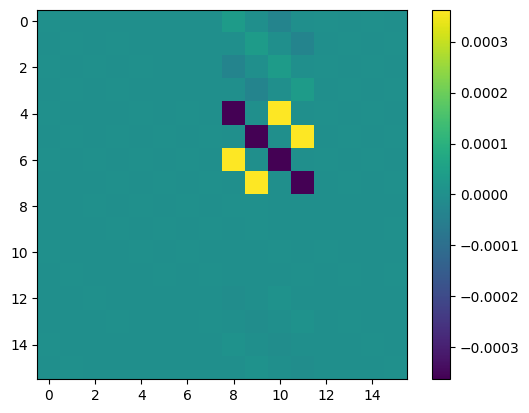

In [282]:
matrix = H_11_m[0]-H_11_a[0]
plt.imshow(matrix)
plt.colorbar()
print(np.max(matrix))

In [283]:
np.max(np.abs(H_11_a[1] - H_11_m[1]))

0.025020391533009223

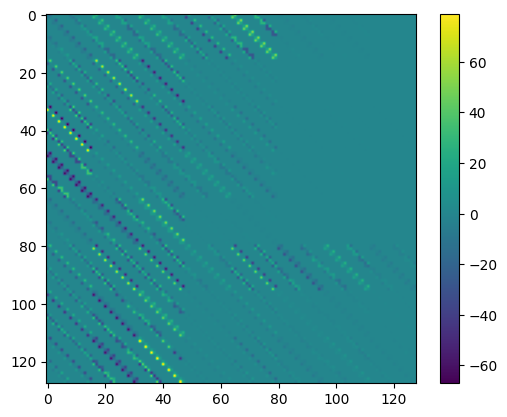

In [284]:
plt.imshow(H_22_m[2][:128, 128:])
plt.colorbar()

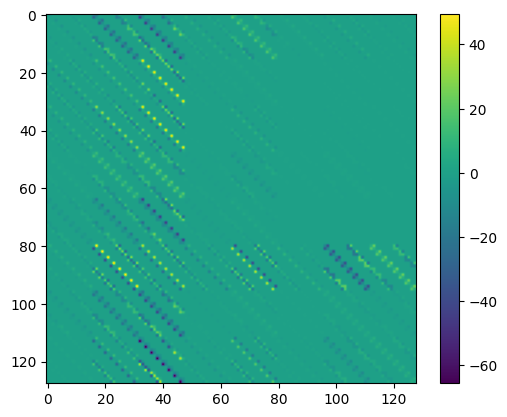

In [285]:
plt.imshow(H_22_a[2][:128, 128:]-H_22_m[2][:128, 128:])
plt.colorbar()

In [231]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [243]:
def check(A, B, rtol=1e-05, atol=1e-08):
    return np.allclose(A, B, rtol=rtol, atol=atol)

In [239]:
check_symmetric(H_11_m[1])

False

In [244]:
check(H_11_m[0], H_11_a[0])

False